In [97]:
%%capture
import os
# Descargamos el dataset
if not os.path.isfile('./partes1t200.zip'):
  !gdown --id 1JHX2aU0hVjRhJP36vanSKheSu5nbu7FT
  !gdown --id 1cWobVXfRMo01Y3zuOFxoVxwiiE6l3ONC
  !gdown --id 1QWg9CXfiPlTdcXi_9SBjdeTcZt-QxTCB
  !gdown --id 1kR5m8Kfq6yALlYc8PIPLz8ktIsFkFT4Q

if not os.path.isdir('./metadata'):
  !mkdir metadata
  !unzip partes1t200.zip -d ./metadata
  !unzip partes201t350.zip -d ./metadata
  !unzip partes351t500.zip -d ./metadata
  !unzip partes501t631.zip -d ./metadata

In [98]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from skimage import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import rescale, resize, downscale_local_mean
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input,MaxPooling2D, Dropout, Embedding, SimpleRNN, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [99]:

# Generador de datos
class DataGenerator(Sequence):

  # imgIDs: Lista de las ID de las imagenes a utilizar en este generator.
  # labels: Diccionario de los labels para cada ID (sin one hot encoding)
  # batch_size: Tamaño de cada batch que se genera por llamado.
  # dim: Dimensiones de las imagenes.
  # n_channels: Numero de canales de la imagen.
  # n_classes: Numero de labels distintos.
  # shuffle: Si revolver los datos o no.
  def __init__(self, imgIDs, text, labels, vectorizer, batch_size=32, dim=(224, 224), n_channels=3, n_classes=4, shuffle=True):
    self.imgIDs = imgIDs
    self.text = text
    self.vectorizer = vectorizer
    self.labels = labels
    self.batch_size = batch_size
    self.dim = dim
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.X_img = []
    self.X_text = []
    self.y_pred = []
    self.on_epoch_end()

  # Retorna el numero de batches del generator.
  def __len__(self):
    return int(np.floor(len(self.imgIDs) / self.batch_size))

  # Retorna un batch.
  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    list_IDs_temp = [self.imgIDs[k] for k in indexes]
    X, y = self.__data_generation(list_IDs_temp)
    return X, y

  # Cuando se termina un epoch, se escogen los siguientes ID.
  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgIDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  # Se cargan los datos a medida que se necesitan.
  def __data_generation(self, list_IDs_temp):
    X_img = np.empty((self.batch_size, *self.dim, self.n_channels))
    X_txt = []
    y = np.empty((self.batch_size), dtype=int)
    
    for i, ID in enumerate(list_IDs_temp):
      rgb = io.imread("./metadata/balanced_dataset_medium/data/" + ID + ".jpg")
      resized_image = resize(rgb, self.dim)
      rescaled_image = 255 * resized_image
      final_image = rescaled_image.astype(np.uint8)
      X_txt.append(self.text[ID])
      X_img[i,] = final_image
      y[i] = self.labels[ID]
    X_txt = self.vectorizer(np.array(X_txt)).numpy()
    X_img = X_img.astype(np.uint8)
    return [X_txt, X_img], to_categorical(y, num_classes=self.n_classes)

(180, 320, 3)

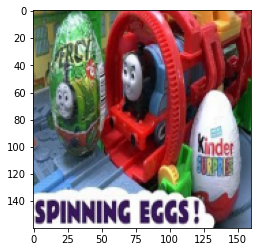

In [100]:
rgb = io.imread("./metadata/balanced_dataset_medium/data/idXBOjJE8oFIY_video.jpg")
resized_image = resize(rgb, (160, 160))
# Convert the image to a 0-255 scale.
rescaled_image = 255 * resized_image
# Convert to integer data type pixels.
final_image = rescaled_image.astype(np.uint8)
# show resized image
plt.imshow(final_image)
rgb.shape

In [101]:
# Observamos los datos del CSV.
data_info_1 =  pd.read_csv("/content/metadata/balanced_dataset_medium/data_info.csv")
data_info_2 =  pd.read_csv("/content/metadata/balanced_dataset_medium/data_info2.csv")
data_info_3 =  pd.read_csv("/content/metadata/balanced_dataset_medium/data_info3.csv")
data_info_4 =  pd.read_csv("/content/metadata/balanced_dataset_medium/data_info4.csv")

dataInfo = pd.concat(map(pd.read_csv, ['/content/metadata/balanced_dataset_medium/data_info.csv', '/content/metadata/balanced_dataset_medium/data_info2.csv', '/content/metadata/balanced_dataset_medium/data_info3.csv', '/content/metadata/balanced_dataset_medium/data_info4.csv']))
dataInfo.sort_values('channelName')

,Unnamed: 0,ID,part,label,views,comments,likes,dislikes,topicID,title,description,channelName,tags
8521,8521,idJBetgAthwHY_video,part291,2,129511,0.0,NaN,NaN,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9 /m/03glg,20 coches chulos machbox. muchos coches difere...,sigo mostrando las colecciones de coches y est...,!Los juguetes divertidos adelante!,vídeos de desarrollo para los niños para los n...
12852,12852,idyZ1cFUjPUqA_video,part601,2,171111,0.0,185.0,78.0,/m/019_rr /m/019_rr /m/07yv9 /m/03glg,muchas sorpresas con coches. huevos con sorpre...,¿qué ha traído el transportador mack? ¿qué han...,!Los juguetes divertidos adelante!,videos para niños sorpresas huevos con sorpres...
4599,4599,idNuvIyjL9GSo_video,part382,0,9439,0.0,30.0,1.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9,"""bicycle"" film pitch video",support the film here: https://www.indiegogo.c...,"""Bicycle"" a Feature Documentary : now filming ...",bicycle cycling bradley wiggins (cyclist) chri...
456,456,idhxhKESvxVE8_video,part265,0,1711,2.0,8.0,0.0,/m/07yv9,экспедиция матвея шпаро и бориса смолина,экспедиция матвея шпаро и бориса смолина к сев...,"""Большое Приключение"", детские лагеря Дмитрия ...",шпаро shparo смолин северный полюс полярная но...
13162,13162,idXa1Uuibc0do_video,part566,2,561773,145.0,1637.0,112.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9,carro de ladrão,esse video ta show,#***Alberto***# ............,carro de ladrão
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10165,10165,idzYCrcvwJQQ4_video,part620,1,38382,54.0,343.0,4.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9,bmw driving center m5 m-taxi 체험기 -홍방장,홍방장의 유투브 구독하기링크: http://goo.gl/fmwtlx\n홍방장의 일상...,홍방장,afreecatv 아프리카 게임 video game 홍방장 bmw m5 (autom...
179,179,idmjoBMxti8jw_video,part355,0,7461,0.0,9.0,0.0,/m/019_rr /m/019_rr /m/07yv9,세부여행 호핑투어. cebu travel day3,세부여행을 하며 호핑투어를 즐겼습니다.\n세부여행에 관해 궁금한 점은 덧글 남겨주세...,힐링아시아,해외여행 travel 세부여행 호핑투어 세부호핑투어 cebu travel
8366,8366,idJarxYu7H0z8_video,part291,1,12293,2.0,4.0,0.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9,【前面展望】近鉄鈴鹿線 平田町ー鈴鹿市,f1の街・鈴鹿市を行きますよ。今回は交換付きで。\r\n\r\nニコニコ版→http://w...,（ほぼ）ひたすら前面展望！～OleOleSaggyの乗り物動画～,前面展望 鉄道 近鉄 鈴鹿線 三重 鈴鹿
6971,6971,idqrqx8EqlN-A_video,part439,1,56824,8.0,56.0,5.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9,姫トラ デコトラ エサ屋 白銀ペイント 雪道走行,カミオン２０１５年２月１日発売の道連れフォトストーリーに掲載されてます。ペイントは白銀社。,ｙｕｍｉｍａｒｕ,tiger (animal) animal (film genre) 姫トラ デコトラ アー...


In [102]:
dataInfo = dataInfo.dropna()

df2 = dataInfo[(dataInfo['label'] == 0)]
df3 = dataInfo[(dataInfo['label'] == 1)]
df4 = dataInfo[(dataInfo['label'] == 2)]
df5 = dataInfo[(dataInfo['label'] == 3)]

vals = len(df5)

df6 = df2.iloc[:vals]
df7 = df3.iloc[:vals]
df8 = df4.iloc[:vals]

bigdata = pd.concat([df5, df6, df7, df8], ignore_index=True, sort=False)
bigdata

,Unnamed: 0,ID,part,label,views,comments,likes,dislikes,topicID,title,description,channelName,tags
0,24,idWsnKzK6dX8Q_video,part558,3,1573462,446.0,4800.0,186.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9,top gear | new self-driving bmw 330i | 720p hd...,top gear: new bmw 330 series self operating ca...,Phone and a Drone,top gear bmw 330 new self driving operating no...
1,30,idWU4EjctBYDE_video,part558,3,1072849,60.0,2664.0,564.0,/m/019_rr /m/019_rr /m/03glg /m/07yv9,cars hot wheels scorpion takedown race track c...,hot wheels scorpion takedown race track testin...,DCTC Toy Channel,cars hot wheels cars 2 hot wheels scorpion tak...
2,32,idWtexxtwHeJI_video,part558,3,4313505,52.0,2558.0,1213.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9 /m/03glg,monster trucks for kids - learn numbers and co...,monster trucks for kids is fun. learn numbers ...,Blippi,monster trucks videos for kids blippi learn co...
3,33,idwSuH9u0kvhU_video,part558,3,2681546,465.0,8154.0,479.0,/m/019_rr /m/019_rr /m/07yv9,rob higgs,amazing sculpture !!,Emeline,sculture rob higgs machinery mechanical art
4,34,idUldAnqLiAKs_video,part514,3,1740134,504.0,2880.0,93.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9 /m/0410tth,bmx dirt jumping - red bull elevation 2008 - f...,the fourth red bull elevation - one of the wor...,redbullusa,elevation bmx dirt jumping jump contest 2008 w...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5363,11619,idj0KcONM5HoI_video,part287,2,374507,11.0,121.0,62.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9 /m/03glg,stafford and thomas with annie & clarabel trac...,http://www.youtube.com/playlist?list=plf_gonhu...,Hulyan Maya,trains trackmaster trackmaster new for 2013 to...
5364,11620,idJ-DrgZHpS3E_video,part287,2,239065,129.0,1035.0,37.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9,คลิปโฆษณา honda city 2014 ตัวเต็ม,ติดตามข่าว honda city 2014: http://www.thaihon...,Gamez Automoblex,honda city 2014 city 2014 ฮอนด้าซิตี้ 2014 ซิต...
5365,11622,idj-XWF5GhnCk_video,part287,2,150195,229.0,269.0,453.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9,surviving the lufthansa economy hell,we did survive the hell of an economy flight b...,bloggi,shanghai seat satire onboard munich lufthansa ...
5366,11623,idI_xgTbMGozg_video,part287,2,352306,29.0,329.0,33.0,/m/07yv9,"катастрофы, крушения, аварии и падения кранов #2","новая подборка крушений, аварий и падений кра...",Кран Манипулятор,подборка автокран упал падение катастрофа пере...


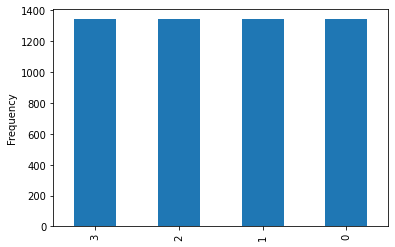

In [103]:
value_counts2 = bigdata['label'].value_counts()
value_counts2

bigdata.groupby('label').size().plot.hist()
bigdata['label'].value_counts().plot.bar()

In [104]:
# Tamaño de los grupos, donde se indica con proporciones.
# El resto se le asigna al grupo de test.
trainSize = 0.6
valSize = 0.2

# Generamos el diccionario de los labels, y cargamos todos los IDs en una lista.
labels = {}
data = []
text = {}
vecText = []

for i, row in bigdata.iterrows():
  vecText.append(row["title"] + " " + row["description"] + " " + row["channelName"])
  text[row["ID"]] = row["title"] + " " + row["description"] + " " + row["channelName"]
  data.append(row["ID"])
  labels[row["ID"]] = row["label"]

# Revolvemos la lista de ID.
random.Random().shuffle(data)

# Generamos las listas de IDs para cada grupo.
trainData = data[:int(len(data)*trainSize)]
valData = data[int(len(data)*trainSize) : int(len(data)*trainSize) + int(len(data)*valSize)]
testData = data[int(len(data)*trainSize) + int(len(data)*valSize):]

# Creamos el diccionario de listas de ID para cada grupo.
partition = {}
partition["train"] = trainData
partition["validation"] = valData
partition["test"] = testData

In [105]:
maxLen = max(len(a.split()) for a in vecText)
print(maxLen)

849


In [106]:
#inicialización del metodo que vectoriza el texto, se le ingresa el vocabulario a codificar
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=maxLen)
text_ds = tf.data.Dataset.from_tensor_slices(np.array(vecText)).batch(128)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))



---


**Data Generators**

---



In [107]:
# Creamos los generadores.
trainGenerator = DataGenerator(partition["train"], text, labels, vectorizer)
valGenerator = DataGenerator(partition["validation"], text, labels, vectorizer)
testGenerator = DataGenerator(partition["test"], text, labels, vectorizer)

In [108]:
PATH = './metadata/balanced_dataset_medium/'
train_dir = os.path.join(PATH, 'data')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)


In [109]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [110]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [111]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

17612800/17605208 [==============================] - 0s 0us/step


In [112]:
iterable = iter(trainGenerator)
for i in range(3):
  X, labels = next(iterable)
#feature_batch = base_model(image_batch)
#print(feature_batch.shape)

[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


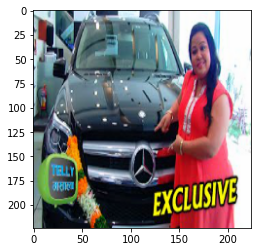

In [113]:
#len(X[0])
plt.imshow(X[1][2])
print(labels)

In [114]:
bigdata[bigdata.ID == "id_cAeQmm6FL8_video"].to_csv('1168.csv')

In [115]:
base_model.trainable = False

In [116]:
if not os.path.isfile('./glove.42B.300d.txt'):
  !gdown --id 1gwdbSac4nlb66wHc-LpOkvlSNBTN5aoX

In [117]:
#Lee matrices del embedding
embeddings_index = {}
f = open('./glove.42B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1917494 word vectors.


In [118]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [119]:
embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=maxLen,
                            trainable=False)

In [120]:
prediction_layer = tf.keras.layers.Dense(32, activation='sigmoid')
pooling_layer = tf.keras.layers.GlobalAveragePooling2D()

In [121]:
#modelo de imagenes
IMGinput = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(IMGinput)
x = base_model(x, training=False)
x = pooling_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Flatten()(x)
#x = tf.keras.layers.Dense(1280, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.4)(x)
IMGoutput = prediction_layer(x)
model_img = tf.keras.Model(IMGinput, IMGoutput)

In [122]:
embedding_dim = 128

In [123]:
#modelo de texto
model_text = Sequential([
  embedding_layer,
  tf.keras.layers.GRU(embedding_dim, return_sequences=True),
  tf.keras.layers.GRU(embedding_dim),
  Dense(embedding_dim/4, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  Dense(32, activation='sigmoid')
])

In [124]:
model_img.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                40992     
Total params: 4,267,424
Trainable params: 40,992
Non-trainable params: 4,226,432
_________________________________________________________________


In [125]:
model_text.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 849, 300)          6000300   
_________________________________________________________________
gru_8 (GRU)                  (None, 849, 128)          165120    
_________________________________________________________________
gru_9 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_23 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1056      
Total params: 6,269,676
Trainable params: 269,376
Non-trainable params: 6,000,300
______________________________________

In [126]:
# input_text = tf.keras.Input(shape=(300,))
# x2 = embedding_layer(input_text)
# x2 = tf.keras.layers.GRU(embedding_dim, return_sequences=True)(input_text)
# x2 = tf.keras.layers.GRU(embedding_dim)(x2)

x3 = tf.keras.layers.concatenate([model_text.output, model_img.output])
x3 = Dense(32, activation='sigmoid')(x3)
#x3 = tf.keras.layers.Dropout(0.2)(x3)

output = Dense(4, activation='softmax')(x3)
model = tf.keras.Model([model_text.input, IMGinput], output)

In [127]:
base_learning_rate = 0.0001
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [128]:
stopping = EarlyStopping(monitor='val_loss', patience=8)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)

In [129]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_2_input (InputLayer)  [(None, 849)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 849, 300)     6000300     embedding_2_input[0][0]          
__________________________________________________________________________________________________
gru_8 (GRU)                     (None, 849, 128)     165120      embedding_2[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
____________________________________________________________________________________________

In [130]:
history = model.fit(trainGenerator, validation_data=valGenerator, epochs = 100, callbacks=[stopping, reduce_lr])

Epoch 1/100
100/100 [==============================] - 139s 719ms/step - loss: 1.4132 - accuracy: 0.2612 - val_loss: 1.3931 - val_accuracy: 0.2396
Epoch 2/100
100/100 [==============================] - 67s 673ms/step - loss: 1.3806 - accuracy: 0.2744 - val_loss: 1.3724 - val_accuracy: 0.3059
Epoch 3/100
100/100 [==============================] - 67s 674ms/step - loss: 1.3616 - accuracy: 0.3262 - val_loss: 1.3505 - val_accuracy: 0.3362
Epoch 4/100
100/100 [==============================] - 67s 665ms/step - loss: 1.3321 - accuracy: 0.3650 - val_loss: 1.3263 - val_accuracy: 0.3930
Epoch 5/100
100/100 [==============================] - 66s 665ms/step - loss: 1.3119 - accuracy: 0.3844 - val_loss: 1.3137 - val_accuracy: 0.3949
Epoch 6/100
100/100 [==============================] - 66s 664ms/step - loss: 1.2944 - accuracy: 0.3997 - val_loss: 1.3128 - val_accuracy: 0.3797
Epoch 7/100
100/100 [==============================] - 66s 663ms/step - loss: 1.2729 - accuracy: 0.4156 - val_loss: 1.3147 

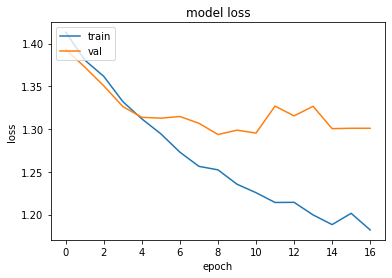

In [131]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

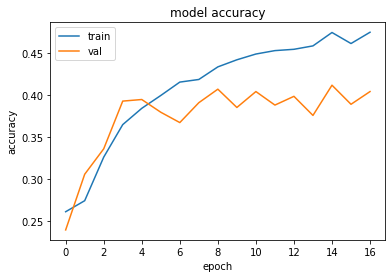

In [132]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [133]:
y_pred = []
y_real = []
for x,y in testGenerator:
  y_real.append(y)
  y_pred.append(model.predict(x))

In [134]:
y_predicted = []
y_true = []

for i in range(len(y_pred)):
  for j in range(len(y_pred[i])):
    y_predicted.append(np.argmax(y_pred[i][j]))
    y_true.append(np.argmax(y_real[i][j]))

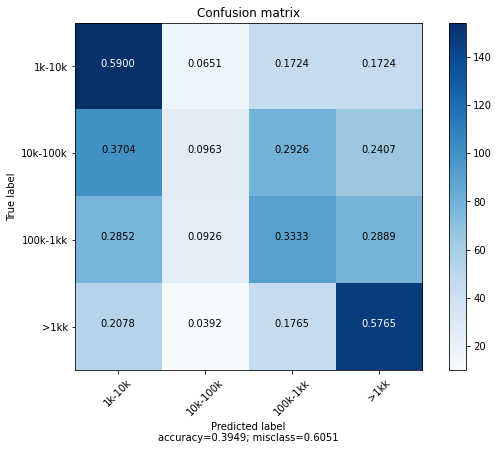

In [135]:
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix as cf
from sklearn.metrics import classification_report


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

c_m = cf(y_true, y_predicted)
plot_confusion_matrix(c_m,["1k-10k", "10k-100k","100k-1kk",">1kk"])